In [1]:
from annoy import AnnoyIndex
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, auc, classification_report, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pprint
import pandas as pd
import xgboost as xgb

In [2]:
train_df = pd.read_csv('data.csv')
test_df = pd.read_parquet('data-val.parquet')

In [3]:
## Make sure that the dataset 

# Find common columns
common_columns = train_df.columns.intersection(test_df.columns)

# Drop uncommon columns
removed_columns = set(train_df.columns).symmetric_difference(test_df.columns)
train_df_filtered = train_df[common_columns]
test_df_filtered = test_df[common_columns]

# Print removed columns
print("Removed columns:", removed_columns)

Removed columns: {'SUM_NOT_TRANSFER_3m', 'SUM_AMT_TRANSFER_3m', 'Unnamed: 0.1'}


In [4]:
# Comparing number of columns
print("Train data:", train_df_filtered.shape[1])
print("Test data:", test_df_filtered.shape[1])

Train data: 57
Test data: 57


In [5]:
## Dropping irrelavant columns

# Train_data
train_df_filtered = train_df_filtered.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

# Test_data 
test_df_filtered = test_df_filtered.drop(columns=['Age_x','CIF_CLSCUS', 'COB_DATE', 'DATE_TIME', 'BRN_OPN_CIF', 'MA_PHONG_GIAO_DICH_VCB', 'CIF_MASK', 'IS_TM', 'Unnamed: 0', 'SUM_CBALQ_LH_6m', 'SUM_CBALQ_LH_3m', 'AVG_GR_SUM_CBALQ_LH'])

In [6]:
# Comparing number of columns
print("Train data:", train_df_filtered.shape[1])
print("Test data:", test_df_filtered.shape[1])
print('Selected columns:\n', test_df_filtered.columns)

Train data: 45
Test data: 45
Selected columns:
 Index(['CBALQ_3m', 'AVG_SL_SP_BOSUNG', 'NO_TREN_CO_6m',
       'LOAIHINHCOQUANDANGCONGTAC', 'SUM_CBALQ_LH', 'BHNT_flag',
       'MEDIAN_GR_SUM_AMT', 'TINHTRANGSOHUUNHA', 'TINHTRANGHONNHAN', 'Khu_vuc',
       'BHNT_after21', 'Sum_PPC', 'MEDIAN_GR_THGCO', 'BHSK_remain',
       'IS_BANCAS', 'AVG_GR_CBALQ', 'CBALQ_6m', 'AVG_CBALQ_6m', 'BHNT_remain',
       'AVG_GR_THGCO', 'IS_TM.1', 'Age_y', 'THGCO_3m', 'CNT_TGCCKH',
       'THGNO_6m', 'IS_TA', 'TONGTHUNHAPHANGTHANG', 'Snapshot', 'BHSK_flag',
       'THGCO_6m', 'MEDIAN_GR_CBALQ', 'AVG_CBALQ_TGCCKH', 'THGNO_3m',
       'TINHCHATCONGVIECHIENTAI', 'AVG_AMT_3M', 'NO_TREN_CO_3m',
       'AVG_CBALQ_3m', 'Prio_flag', 'SONGUOIPHUTHUOC', 'THOIGIANLAMVIECLVHT',
       'BHSK_after21', 'Payroll_Flag', 'AVG_GR_THGNO', 'CUS_GEN',
       'MEDIAN_GR_THGNO'],
      dtype='object')


In [7]:
## Labelling
def labelling (df, col, num_bins):
    df[col] = pd.qcut(df[col], q=num_bins, labels=False, duplicates='drop')
    return df
for col in ['AVG_AMT_3M', 'AVG_CBALQ_3m', 'AVG_CBALQ_6m', 'AVG_CBALQ_TGCCKH',
       'AVG_GR_CBALQ', 'AVG_GR_THGCO', 'AVG_GR_THGNO', 'AVG_SL_SP_BOSUNG',
        'CBALQ_3m', 'CBALQ_6m', 'CNT_TGCCKH', 'MEDIAN_GR_CBALQ',
       'MEDIAN_GR_SUM_AMT', 'MEDIAN_GR_THGCO', 'MEDIAN_GR_THGNO',
       'NO_TREN_CO_3m', 'NO_TREN_CO_6m', 'SUM_CBALQ_LH', 'Snapshot', 'Sum_PPC',
       'THGCO_3m', 'THGCO_6m', 'THGNO_3m', 'THGNO_6m', 'TONGTHUNHAPHANGTHANG']:
    train_df = labelling(train_df_filtered, col, 10)
    test_df = labelling(test_df_filtered, col, 10)

age_bin_edges = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, float('inf')]
labels = ['Duoi 20', '20 toi 24', '25 toi 29', '30 toi 34', '35 toi 39', '40 toi 44', '45 toi 49', '50 toi 54', '55 toi 59', 'Tren 60']

train_df['Age_group'] = pd.cut(train_df['Age_y'], bins=age_bin_edges, labels=labels, right=False)
test_df['Age_group'] = pd.cut(test_df['Age_y'], bins=age_bin_edges, labels=labels, right=False)

/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/zeus/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtrac

In [8]:
## Collaborative search

# Step 1: Handle missing values and ensure consistent data types
def handle_missing_values(df):
    df = df.astype(str)
    df = df.fillna("None")
    return df

# Step 2: Preprocess - Encoding categorical variables
def preprocess_data(df, target_column, transformer=None):
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Reset indices for alignment with Annoy
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Handle missing values and ensure consistent data types
    X = handle_missing_values(X)

    if transformer is None:
        transformer = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), X.columns.tolist())
            ],
            remainder='passthrough'
        )
        transformer.fit(X)
    
    # Transform features
    X_transformed = transformer.transform(X)
    return X_transformed.astype(np.float32), y.astype(float), transformer

# Step 3: Create Annoy Index
def create_annoy_index(df, target_column, n_neighbors=20):
    # Preprocess the data and separate features and target
    X, y, transformer = preprocess_data(df, target_column)
    
    # Initialize Annoy index
    annoy_index = AnnoyIndex(X.shape[1], 'angular')
    
    # Add items to the Annoy index
    for i, vector in enumerate(X):
        annoy_index.add_item(i, vector)
    
    # Build the index
    annoy_index.build(100)
    
    return annoy_index, X, y, transformer  # Return y for later use
    
bessa và Cai

In [9]:
# Training
target_column = 'IS_BANCAS'
annoy_index, _, y_train, transformer = create_annoy_index(train_df, target_column)

# Save the Annoy index to a file
annoy_index.save('results/annoy_index.ann')

# Save the transformer and y_train using pickle
with open('results/collaborative_search_model.pkl', 'wb') as f:
    pickle.dump((transformer, y_train), f)


In [10]:
# Testing

## On training data

### Collaborative search
y_pred_col_train = predict_nba(train_df, target_column, annoy_index, transformer, y_train)
y_pred_col_train_round = y_pred_col_train.round()

## On testing data
y_pred_col_test = predict_nba(test_df, target_column, annoy_index, transformer, y_train)
y_pred_col_test_round = y_pred_col_test.round()

In [11]:
y_test = test_df[target_column]

In [12]:
# Reporting

## On training data
print('\nTESTING ON TRAINING DATA:\n')



accuracy_col_train = accuracy_score(y_train, y_pred_col_train_round)
accuracy_col_train = round(accuracy_col_train, 4)
roc_auc_score_col_train = roc_auc_score(y_train, y_pred_col_train)
gini_col_train = 2 * roc_auc_score_col_train -1

print('Model Accuracy:', str(accuracy_col_train * 100))
print('\nClassification Report:')
print(classification_report(y_train, y_pred_col_train_round))
print("ROC AUC Score:", roc_auc_score_col_train.round(2))
print("Gini Index:", gini_col_train.round(2))


## On testing data
print('\nTESTING ON TESTING DATA:\n')



accuracy_col_test = accuracy_score(y_test, y_pred_col_test_round)
accuracy_col_test = round(accuracy_col_test, 4)
roc_auc_score_col_test = roc_auc_score(y_test, y_pred_col_test)
gini_col_test = 2 * roc_auc_score_col_test -1

print('Model Accuracy:', str(accuracy_col_test * 100) + '%')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_col_test_round))
print("ROC AUC Score:", roc_auc_score_col_test.round(2))
print("Gini Index:", gini_col_test.round(2))



TESTING ON TRAINING DATA:

Model Accuracy: 95.85000000000001

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98   1036620
         1.0       0.63      0.31      0.41     51831

    accuracy                           0.96   1088451
   macro avg       0.80      0.65      0.70   1088451
weighted avg       0.95      0.96      0.95   1088451

ROC AUC Score: 0.93
Gini Index: 0.85

TESTING ON TESTING DATA:

Model Accuracy: 95.00999999999999%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    130200
         1.0       0.43      0.15      0.23      6510

    accuracy                           0.95    136710
   macro avg       0.70      0.57      0.60    136710
weighted avg       0.93      0.95      0.94    136710

ROC AUC Score: 0.75
Gini Index: 0.5


In [13]:
# ROC Curves

## Train data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_col_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Insert root point (0,0) into fpr and tpr
fpr_train = [0] + list(fpr_train)
tpr_train = [0] + list(tpr_train)

## Test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_col_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Insert root point (0,0) into fpr and tpr
fpr_test = [0] + list(fpr_test)
tpr_test = [0] + list(tpr_test)

In [14]:
# Colours
background_color = '#181926'
text_colour = "#cad3f5"
axis_colour = "#b8c0e0"
guess_colour = '#8aadf4'
roc_train_colour = "#f0c6c6"
roc_test_colour = "#91d7e3"


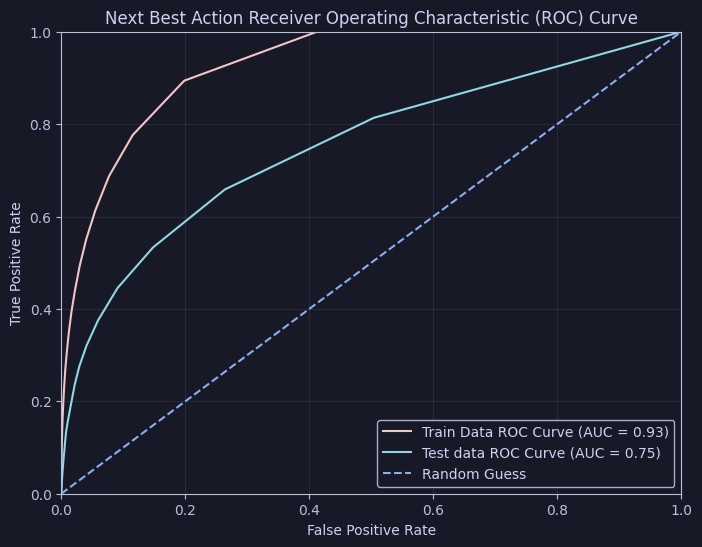

In [15]:
# Setting up the plot
plt.figure(figsize=(8, 6), facecolor=background_color)
ax = plt.gca()  # Get the current Axes
ax.set_facecolor(background_color)  # Set the background color of the Axes

# Customize axis colors
ax.tick_params(axis='x', colors=axis_colour)  # Set x-axis tick color
ax.tick_params(axis='y', colors=axis_colour)  # Set y-axis tick color
ax.spines['bottom'].set_color(axis_colour)  # Set bottom spine color
ax.spines['left'].set_color(axis_colour)    # Set left spine color
ax.spines['top'].set_color(axis_colour)  # Set bottom spine color
ax.spines['right'].set_color(axis_colour)    # Set left spine color

# Plotting

# Plot the ROC curve
plt.plot(fpr_train, tpr_train, color=roc_train_colour, label=f'Train Data ROC Curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color=roc_test_colour, label=f'Test data ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color=guess_colour, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate', color=text_colour)  # White text for better contrast
plt.ylabel('True Positive Rate', color=text_colour)  # White text for better contrast
plt.title('Next Best Action Receiver Operating Characteristic (ROC) Curve', color=text_colour)
plt.legend(loc='lower right', facecolor=background_color, edgecolor=text_colour, labelcolor=text_colour)
plt.grid(alpha=0.1, color=axis_colour)  # Adjust grid line color for visibility

# Set the x and y limits to start at 0
plt.xlim(0, 1)  # x-axis starts at 0
plt.ylim(0, 1)  # y-axis starts at 0

plt.show()